In [31]:
import os
import librosa, random
import IPython.display as ipd
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import wavfile
import warnings

warnings.filterwarnings("ignore")
%matplotlib inline

In [2]:
train_audio_path = 'audio/'

In [4]:
samples, sample_rate = librosa.load(train_audio_path+'cat/004ae714_nohash_0.wav', sr = 16000)

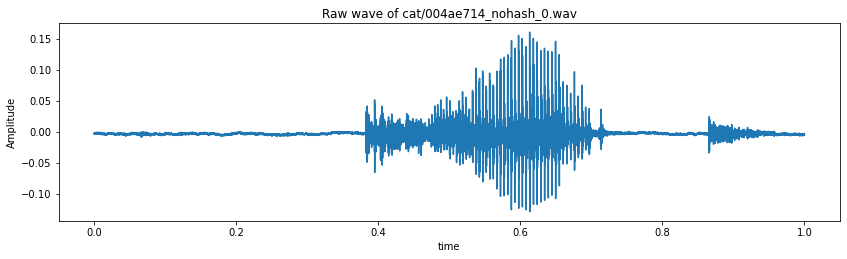

In [5]:
fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(211)
ax1.set_title('Raw wave of ' + 'cat/004ae714_nohash_0.wav')
ax1.set_xlabel('time')
ax1.set_ylabel('Amplitude')
ax1.plot(np.linspace(0, sample_rate/len(samples), sample_rate), samples)

In [6]:
ipd.Audio(samples, rate=sample_rate)

In [7]:
print(sample_rate)

16000


In [10]:
samples = librosa.resample(samples, orig_sr=sample_rate, target_sr=8000)
ipd.Audio(samples, rate=8000)

In [11]:
labels=os.listdir(train_audio_path)

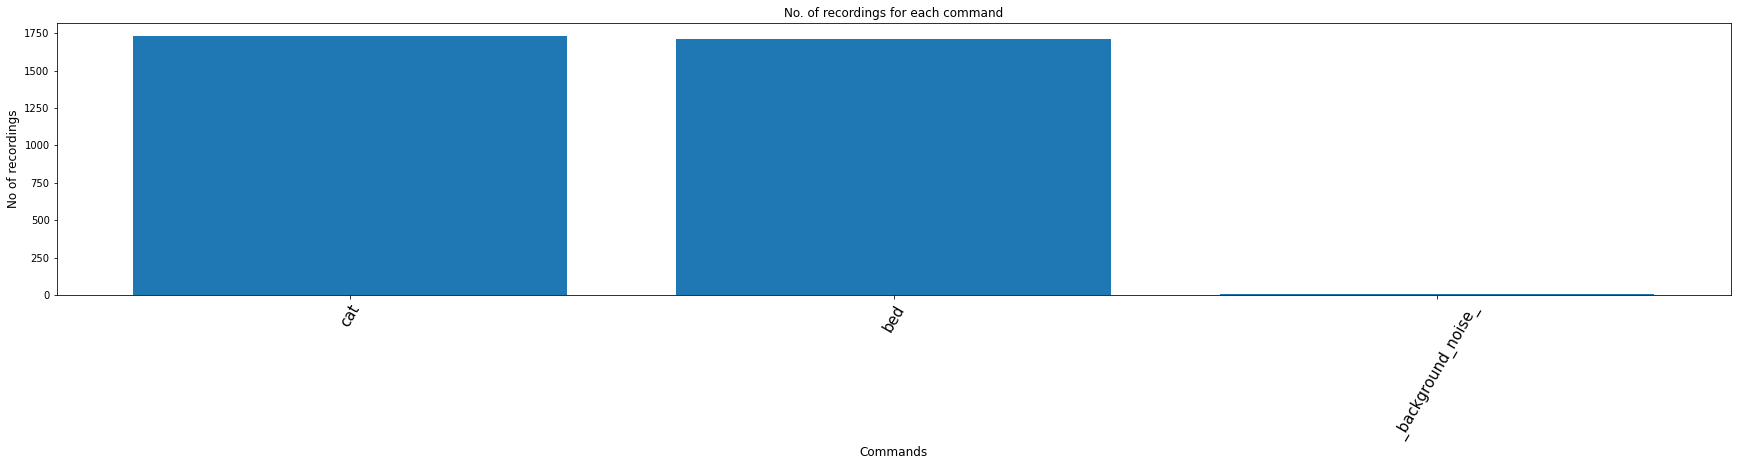

In [12]:
no_of_recordings=[]
for label in labels:
    waves = [f for f in os.listdir(train_audio_path + '/'+ label) if f.endswith('.wav')]
    no_of_recordings.append(len(waves))
    
#plot
plt.figure(figsize=(30,5))
index = np.arange(len(labels))
plt.bar(index, no_of_recordings)
plt.xlabel('Commands', fontsize=12)
plt.ylabel('No of recordings', fontsize=12)
plt.xticks(index, labels, fontsize=15, rotation=60)
plt.title('No. of recordings for each command')
plt.show()

In [13]:
labels=["cat", "bed", "_background_noise_"]

(array([3.444e+03, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        5.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([ 0.469375,  9.94075 , 19.412125, 28.8835  , 38.354875, 47.82625 ,
        57.297625, 66.769   , 76.240375, 85.71175 , 95.183125]),
 <BarContainer object of 10 artists>)

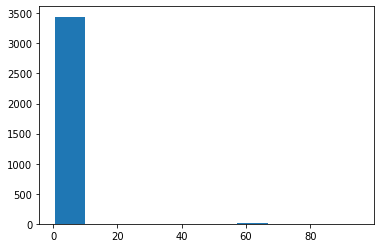

In [14]:
duration_of_recordings=[]
for label in labels:
    waves = [f for f in os.listdir(train_audio_path + '/'+ label) if f.endswith('.wav')]
    for wav in waves:
        sample_rate, samples = wavfile.read(train_audio_path + '/' + label + '/' + wav)
        duration_of_recordings.append(float(len(samples)/sample_rate))
    
plt.hist(np.array(duration_of_recordings))

In [16]:
train_audio_path = 'audio/'

all_wave = []
all_label = []
for label in labels:
    print(label)
    waves = [f for f in os.listdir(train_audio_path + '/'+ label) if f.endswith('.wav')]
    for wav in waves:
        samples, sample_rate = librosa.load(train_audio_path + '/' + label + '/' + wav, sr = 16000)
        samples = librosa.resample(samples, orig_sr=sample_rate, target_sr=8000)
        if(len(samples)== 8000) : 
            all_wave.append(samples)
            all_label.append(label)

cat
bed
_background_noise_


In [17]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y=le.fit_transform(all_label)
classes= list(le.classes_)

In [21]:
from keras.utils import to_categorical
y=to_categorical(y, num_classes=len(labels))

In [22]:
all_wave = np.array(all_wave).reshape(-1,8000,1)

In [23]:
from sklearn.model_selection import train_test_split
x_tr, x_val, y_tr, y_val = train_test_split(np.array(all_wave),np.array(y),stratify=y,test_size = 0.2,random_state=777,shuffle=True)

In [24]:
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv1D, Input, MaxPooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.python.keras import backend as k
k.clear_session()

inputs = Input(shape=(8000,1))

#First Conv1D layer
conv = Conv1D(8,13, padding='valid', activation='relu', strides=1)(inputs)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Second Conv1D layer
conv = Conv1D(16, 11, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Third Conv1D layer
conv = Conv1D(32, 9, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Fourth Conv1D layer
conv = Conv1D(64, 7, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Flatten layer
conv = Flatten()(conv)

#Dense Layer 1
conv = Dense(256, activation='relu')(conv)
conv = Dropout(0.3)(conv)

#Dense Layer 2
conv = Dense(128, activation='relu')(conv)
conv = Dropout(0.3)(conv)

outputs = Dense(len(labels), activation='softmax')(conv)

model = Model(inputs, outputs)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 8000, 1)]         0         
                                                                 
 conv1d (Conv1D)             (None, 7988, 8)           112       
                                                                 
 max_pooling1d (MaxPooling1  (None, 2662, 8)           0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 2662, 8)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 2652, 16)          1424      
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 884, 16)           0         
 g1D)                                                        

In [25]:
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [26]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, min_delta=0.0001) 
mc = ModelCheckpoint('best_model.hdf5', monitor='val_acc', verbose=1, save_best_only=True, mode='max')

In [27]:
history=model.fit(x_tr, y_tr ,epochs=10, callbacks=[es,mc], batch_size=32, validation_data=(x_val,y_val))

Epoch 1/10
75/75 [==============================] - 9s 68ms/step - loss: 0.7553 - accuracy: 0.4973 - val_loss: 0.7058 - val_accuracy: 0.4950
Epoch 2/10
75/75 [==============================] - 5s 65ms/step - loss: 0.7076 - accuracy: 0.5152 - val_loss: 0.6813 - val_accuracy: 0.6617
Epoch 3/10
75/75 [==============================] - 5s 66ms/step - loss: 0.5854 - accuracy: 0.6980 - val_loss: 0.4706 - val_accuracy: 0.7967
Epoch 4/10
75/75 [==============================] - 5s 65ms/step - loss: 0.4724 - accuracy: 0.8035 - val_loss: 0.4079 - val_accuracy: 0.8417
Epoch 5/10
75/75 [==============================] - 5s 65ms/step - loss: 0.4386 - accuracy: 0.8077 - val_loss: 0.3163 - val_accuracy: 0.8800
Epoch 6/10
75/75 [==============================] - 5s 65ms/step - loss: 0.3649 - accuracy: 0.8440 - val_loss: 0.2690 - val_accuracy: 0.8933
Epoch 7/10
75/75 [==============================] - 5s 65ms/step - loss: 0.3384 - accuracy: 0.8648 - val_loss: 0.2927 - val_accuracy: 0.8900
Epoch 8/10
75

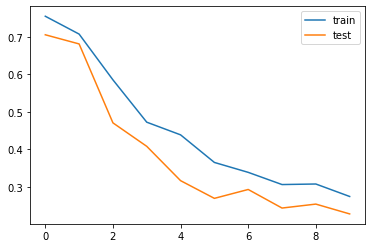

In [28]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [29]:
def predict(audio):
    prob=model.predict(audio.reshape(1,8000,1))
    index=np.argmax(prob[0])
    return classes[index]

In [32]:
index=random.randint(0,len(x_val)-1)
samples=x_val[index].ravel()
print("Audio:",classes[np.argmax(y_val[index])])
ipd.Audio(samples, rate=8000)

Audio: cat


In [33]:
print("Text:",predict(samples))

1/1 [==============================] - 0s 112ms/step
Text: cat
